In [1]:
import pandas as pd
import numpy as np
import json, csv, re

In [2]:
"""
This assignment can be done in groups of 3 students. Everyone must submit individually.

Write down the UNIs of your group (if applicable)

Name : Pin-Hao Chen 
Uni  : phc2121

Member 2: Sharon Jong Shiuan Tsao, sjt2141

Member 3: N/A
"""

'\nThis assignment can be done in groups of 3 students. Everyone must submit individually.\n\nWrite down the UNIs of your group (if applicable)\n\nName : Pin-Hao Chen \nUni  : phc2121\n\nMember 2: Pin-Hao Chen, phc2121\n\nMember 3: Sharon Jong Shiuan Tsao, sjt2141\n'

In [3]:
def preprocess(df, preselected_features):
    tmp = df.copy()
    tmp = tmp.drop(columns=preselected_features)
    
    """Phone Number Format"""
    for i, phone_num in enumerate(tmp.phone):
        if not phone_num:
            tmp.loc[i, "phone"] = np.NAN
        else:
            tmp.loc[i, "phone"] = phone_num.replace(" ","").replace("(","").replace(")","").replace("-", "")
    
    """Address Format"""
    for i, address in enumerate(tmp.street_address):
        if not address:
            tmp.loc[i, "street_address"] = np.NAN
        else:
            address = address.lower()
            address = address.replace(" east ", " e. ").replace(" west ", " w. ")
            if tmp.loc[i, "locality"]:
                address += (" %s" % tmp.loc[i, "locality"].lower()) 
            tmp.loc[i, "street_address"] = address.replace(".", "")
    tmp = tmp.drop(columns=["locality"])
    
    """Name Format (Titlize)"""
    tmp.name = tmp.name.str.replace("\'","").replace(".", "")
    tmp.name = tmp.name.str.title()

    """Latitude & Longtitude Format (Round to 3 decimal points)"""
    tmp = tmp.round({"latitude": 3, "longitude": 3})
            
    return tmp

In [4]:
def levDist(str0, str1):
    m, n = len(str0), len(str1)
    v0 = range(n+1)
    v1 = [None] * (n+1) 

    for i in range(m):
        v1[0] = i + 1
        for j in range(n):
            deletion_cost = v0[j+1] + 1
            insertion_cost = v1[j] + 1
            if str0[i] == str1[j]:
                substitution_cost = v0[j]
            else:
                substitution_cost = v0[j] + 1
            v1[j+1] = min(deletion_cost, insertion_cost, substitution_cost)
        v0 = list(v1)
    
    score = 1 - (v0[-1] / v0[0])
    return score

In [5]:
def modelComparsion(df_locu, df_foursquare, threshold):
    df_locu = df_locu.copy()
    df_foursquare = df_foursquare.copy()
    matches = list() # {"locu_id": ..., "foursquare_id": ...}
 
    for i, foursquare_id in enumerate(df_foursquare.id):
        candidate = ""
        max_score = threshold
        for j, locu_id in enumerate(df_locu.id):
            score = 0                    
            if df_foursquare.loc[i, "phone"] == df_locu.loc[j, "phone"]:
                score += 1
            if df_foursquare.loc[i, "street_address"] == df_locu.loc[j, "street_address"]:
                score += 1
            if df_foursquare.loc[i, "latitude"] == df_locu.loc[j, "latitude"] and df_foursquare.loc[i, "longitude"] == df_locu.loc[j, "longitude"]:
                score += 0.5

            score += levDist(df_foursquare.loc[i, "name"], df_locu.loc[j, "name"])
                    
            if score > max_score:
                candidate = locu_id
                max_score = score
        # Comparsion complete
        if candidate:
            matches.append({"locu_id": candidate, "foursquare_id": foursquare_id})
            df_locu = df_locu.drop(df_locu[df_locu.id == candidate].index)
            df_locu.index = range(len(df_locu))
        #print(matches)
    return pd.DataFrame(data=matches, columns=["locu_id", "foursquare_id"])

In [6]:
def confusionMatrix(df_pred, df_real):
    df_pred = df_pred.copy()
    df_real = df_real.copy()
    TP = FP = FN = 0
    for i, pred in df_pred.iterrows():
        if len(df_real[(df_real.locu_id == pred.locu_id)]) > 0:
            if len(df_real[(df_real.locu_id == pred.locu_id) & (df_real.foursquare_id == pred.foursquare_id)]) > 0:
                TP += 1
            else:
                FP += 1
            df_real = df_real.drop(df_real[df_real.locu_id == pred.locu_id].index)
        else:
            FP += 1
    FN = len(df_real)

    return TP, FP, FN 

In [7]:
def get_matches(locu_train_path, foursquare_train_path, matches_train_path, locu_test_path, foursquare_test_path):
    """
        In this function, You need to design your own algorithm or model to find the matches and generate
        a matches_test.csv in the current folder.

        you are given locu_train, foursquare_train json file path and matches_train.csv path to train
        your model or algorithm.

        Then you should test your model or algorithm with locu_test and foursquare_test json file.
        Make sure that you write the test matches to a file in the same directory called matches_test.csv.

    """
    
    """train data"""
    locu_train = pd.read_json(locu_train_path)
    foursquare_train = pd.read_json(foursquare_train_path)
    matches_train = pd.read_csv(matches_train_path) # label (results) to compute precision, recall, and F1-score
    
    """preprocess"""
    preselected_features = ["country", "region", "website", "postal_code"]
    locu_train = preprocess(locu_train, preselected_features)
    foursquare_train = preprocess(foursquare_train, preselected_features)

    """build the model"""
    metric = {"precision": [], "recall": [], "f1": []}
    params = [0.5, 0.6, 0.7, 0.75, 0.775, 0.8, 0.9]
    for threshold in params:
        matches = modelComparsion(locu_train, foursquare_train, threshold)

        """calculate Precision, Recall, and F1-socre"""
        TP, FP, FN = confusionMatrix(matches, matches_train)
        #print(TP, FP, FN)
        precision = TP/(TP+FP)
        recall = TP/(TP+FN)
        f1_score = (2*precision*recall)/(precision+recall)
        print("\nThreshold: %s" % threshold)
        print("Precision: %.4f" % precision)
        print("Recall: %.4f" % recall)
        print("F1 score: %.4f" % f1_score)
        
        metric["precision"].append(precision)
        metric["recall"].append(recall)
        metric["f1"].append(f1_score)
    
    """test data"""
    locu_test = pd.read_json(locu_test_path)
    foursquare_test = pd.read_json(foursquare_test_path)
    
    locu_test = preprocess(locu_test, preselected_features)
    foursquare_test = preprocess(foursquare_test, preselected_features)
    
    """test the model"""
    matches_test = modelComparsion(locu_test, foursquare_test,  params[np.argmax(metric["f1"])])
    
    """output the result"""
    matches_test.to_csv("matches_test.csv", index=False)
    
    return matches_test, metric

In [8]:
matches_test, metric = get_matches("locu_train.json", "foursquare_train.json", "matches_train.csv", "locu_test.json", "foursquare_test.json")


Threshold: 0.5
Precision: 0.8472
Recall: 0.9814
F1 score: 0.9094

Threshold: 0.6
Precision: 0.9016
Recall: 0.9763
F1 score: 0.9375

Threshold: 0.7
Precision: 0.9690
Recall: 0.9773
F1 score: 0.9731

Threshold: 0.75
Precision: 0.9774
Recall: 0.9774
F1 score: 0.9774

Threshold: 0.775
Precision: 0.9830
Recall: 0.9774
F1 score: 0.9802

Threshold: 0.8
Precision: 0.9829
Recall: 0.9746
F1 score: 0.9787

Threshold: 0.9
Precision: 0.9829
Recall: 0.9718
F1 score: 0.9773


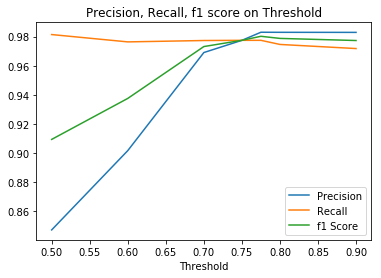

In [10]:
import matplotlib.pyplot as plt
x_axis = [0.5, 0.6, 0.7, 0.75, 0.775, 0.8, 0.9]
plt.plot(x_axis, metric["precision"], label="Precision")
plt.plot(x_axis, metric["recall"], label="Recall")
plt.plot(x_axis, metric["f1"], label="f1 Score")
plt.legend()
plt.title("Precision, Recall, f1 score on Threshold")
plt.xlabel("Threshold")
plt.show()